# **Fine-tuning XLS-R for Multi-Lingual ASR with 🤗 Transformers**

***New (11/2021)***: *This blog post has been updated to feature XLSR's successor, called [XLS-R](https://huggingface.co/models?other=xls_r)*.

## Notebook Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


Before we start, let's install `datasets` and `transformers`. Also, we need the `torchaudio` to load audio files and `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [ ]:
%%capture
!pip install datasets
!pip install transformers==4.11.3
!pip install torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install jiwer

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install transformers[torch]

We strongly suggest to upload your training checkpoints directly to the [🤗 Hub](https://huggingface.co/) while training. The [🤗 Hub](https://huggingface.co/) has integrated version control so you can be sure that no model checkpoint is getting lost during training.

To do so you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!)


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
!apt install git-lfs




---

${}^1$ In the [paper](https://arxiv.org/pdf/2006.13979.pdf), the model was evaluated using the phoneme error rate (PER), but by far the most common metric in ASR is the word error rate (WER). To keep this notebook as general as possible we decided to evaluate the model using WER.

## Prepare Data, Tokenizer, Feature Extractor

### Create `Wav2Vec2CTCTokenizer`

In [ ]:
from datasets import load_dataset
common_voice_train = load_dataset("google/fleurs", "luo_ke", split="train", download_mode="force_redownload", ignore_verifications=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
common_voice_test = load_dataset("google/fleurs", "luo_ke", split="test", ignore_verifications=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Many ASR datasets only provide the target text, `'sentence'` for each audio array `'audio'` and file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. Keeping the notebook as general as possible, we only consider the transcribed text for fine-tuning.



In [ ]:
common_voice_train = common_voice_train.remove_columns(["gender"])
common_voice_test = common_voice_test.remove_columns(["gender"])

In [ ]:
print(common_voice_train.column_names)
print(common_voice_test.column_names)

['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'lang_id', 'language', 'lang_group_id']
['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'lang_id', 'language', 'lang_group_id']


In [ ]:
common_voice_train = common_voice_train.remove_columns([ 'raw_transcription', 'lang_id', 'language', 'lang_group_id'])
common_voice_test = common_voice_test.remove_columns([ 'raw_transcription', 'lang_id', 'language', 'lang_group_id'])

In [ ]:
# Cast the audio column to the desired sampling rate
from datasets import load_dataset, Audio
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
# Verify the total duration for the train split
total_duration_train = sum(len(example["audio"]["array"]) for example in common_voice_train) / 16_000
print(f"Total duration of selected train subset: {total_duration_train / 3600:.2f} hours")

# Verify the total duration for the test split
total_duration_test = sum(len(example["audio"]["array"]) for example in common_voice_test) / 16_000
print(f"Total duration of selected test subset: {total_duration_test / 3600:.2f} hours")

Total duration of selected train subset: 10.12 hours
Total duration of selected test subset: 0.97 hours


Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(common_voice_train.remove_columns(["path", "audio"]), num_examples=10)

In [ ]:
# Print a random sample from the train subset
rand_int_train = random.randint(0, len(common_voice_train) - 1)
print("Train set - Target text:", common_voice_train[rand_int_train]["transcription"])
print("Train set - Input array shape:", common_voice_train[rand_int_train]["audio"]["array"].shape)
print("Train set - Sampling rate:", common_voice_train[rand_int_train]["audio"]["sampling_rate"])

# Print a random sample from the test subset
rand_int_test = random.randint(0, len(common_voice_test) - 1)
print("Test set - Target text:", common_voice_test[rand_int_test]["transcription"])
print("Test set - Input array shape:", common_voice_test[rand_int_test]["audio"]["array"].shape)
print("Test set - Sampling rate:", common_voice_test[rand_int_test]["audio"]["sampling_rate"])

Train set - Target text: buge kod it oboke ma wuoyo kwom yore mag tony e thim thoth miwuoro to buge mawuoyo kwom gwenge migoyoe lwenje to kwan gi tin ahinya
Train set - Input array shape: (253440,)
Train set - Sampling rate: 16000
Test set - Target text: danielle lantagne jalony mar un ewi tuo no ne owacho ni landruogno nyaka bed ni nokel gi jolos kwe go
Test set - Input array shape: (196800,)
Test set - Sampling rate: 16000


## EDA ON LUO

Train Set - Max Length: 94.5 seconds
Train Set - Min Length: 3.06 seconds
Train Set - Average Length: 15.285528523489932 seconds
Train Set - Variance: 54.7127068515354 seconds^2
Train Set - 25th Percentile: 10.62 seconds
Train Set - 50th Percentile (Median): 13.86 seconds
Train Set - 75th Percentile: 18.18 seconds


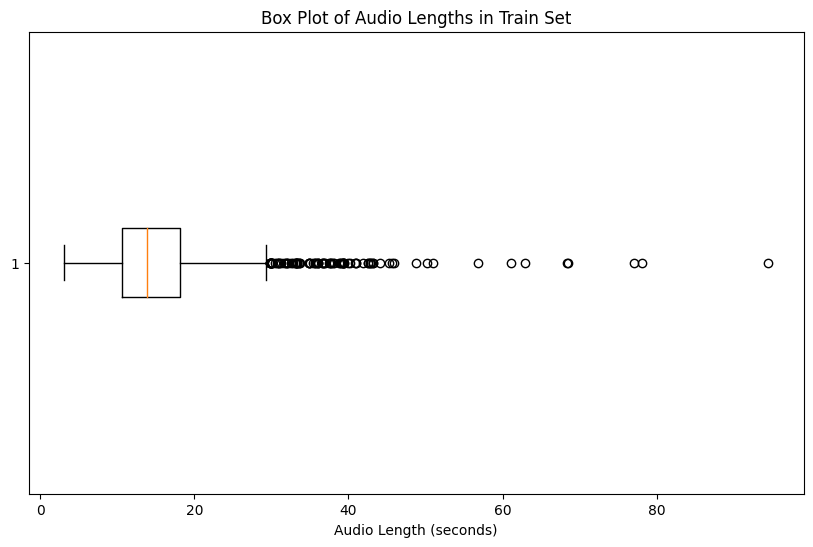

Test Set - Max Length: 35.4 seconds
Test Set - Min Length: 5.22 seconds
Test Set - Average Length: 13.701562500000001 seconds
Test Set - Variance: 21.049438183593747 seconds^2
Test Set - 25th Percentile: 10.365 seconds
Test Set - 50th Percentile (Median): 13.11 seconds
Test Set - 75th Percentile: 16.8 seconds


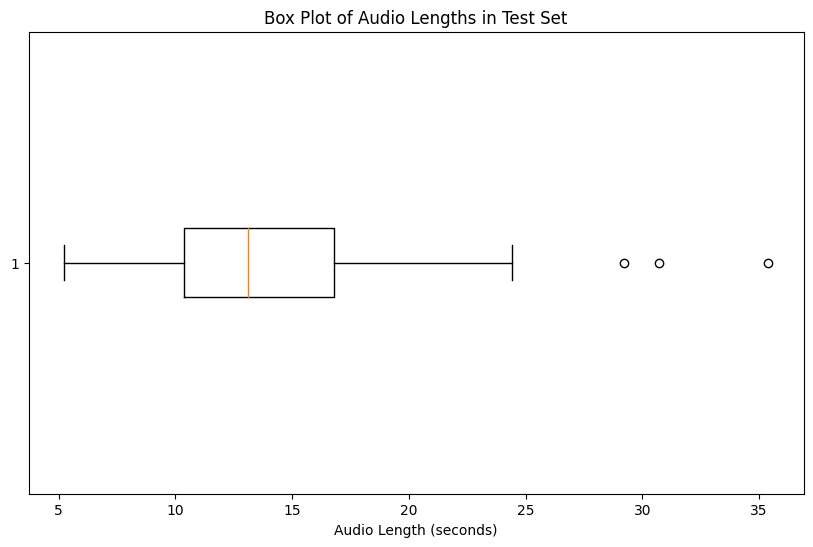

Playing train set audio with maximum length:


Playing train set audio with minimum length:


Playing test set audio with maximum length:


Playing test set audio with minimum length:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def analyze_audio_lengths(dataset, title):
    # Calculate audio lengths in seconds
    audio_lengths = [len(sample["audio"]["array"]) / sample["audio"]["sampling_rate"] for sample in dataset]

    # Calculate statistics
    max_length = np.max(audio_lengths)
    min_length = np.min(audio_lengths)
    avg_length = np.mean(audio_lengths)
    var_length = np.var(audio_lengths)
    percentiles = np.percentile(audio_lengths, [25, 50, 75])

    print(f"{title} - Max Length: {max_length} seconds")
    print(f"{title} - Min Length: {min_length} seconds")
    print(f"{title} - Average Length: {avg_length} seconds")
    print(f"{title} - Variance: {var_length} seconds^2")
    print(f"{title} - 25th Percentile: {percentiles[0]} seconds")
    print(f"{title} - 50th Percentile (Median): {percentiles[1]} seconds")
    print(f"{title} - 75th Percentile: {percentiles[2]} seconds")

    # Plot box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(audio_lengths, vert=False)
    plt.title(f"Box Plot of Audio Lengths in {title}")
    plt.xlabel("Audio Length (seconds)")
    plt.show()

    return audio_lengths, max_length, min_length

# Analyze train and test datasets
train_lengths, train_max_length, train_min_length = analyze_audio_lengths(common_voice_train, "Train Set")
test_lengths, test_max_length, test_min_length = analyze_audio_lengths(common_voice_test, "Test Set")

# Function to play audio
def play_audio(audio_data, sampling_rate):
    import IPython.display as ipd
    return ipd.Audio(audio_data, rate=sampling_rate)

# Play audio with maximum length from train set
max_length_audio_train = common_voice_train[int(np.argmax(train_lengths))]["audio"]
print("Playing train set audio with maximum length:")
display(play_audio(max_length_audio_train["array"], max_length_audio_train["sampling_rate"]))

# Play audio with minimum length from train set
min_length_audio_train = common_voice_train[int(np.argmin(train_lengths))]["audio"]
print("Playing train set audio with minimum length:")
display(play_audio(min_length_audio_train["array"], min_length_audio_train["sampling_rate"]))

# Play audio with maximum length from test set
max_length_audio_test = common_voice_test[int(np.argmax(test_lengths))]["audio"]
print("Playing test set audio with maximum length:")
display(play_audio(max_length_audio_test["array"], max_length_audio_test["sampling_rate"]))

# Play audio with minimum length from test set
min_length_audio_test = common_voice_test[int(np.argmin(test_lengths))]["audio"]
print("Playing test set audio with minimum length:")
display(play_audio(min_length_audio_test["array"], min_length_audio_test["sampling_rate"]))


In [ ]:
# Function to analyze transcript lengths
def analyze_transcript_lengths(dataset, title):
    # Calculate transcript lengths
    transcript_lengths = [len(sample["transcription"]) for sample in dataset]
    # Calculate statistics
    max_length = np.max(transcript_lengths)
    min_length = np.min(transcript_lengths)
    avg_length = np.mean(transcript_lengths)
    var_length = np.var(transcript_lengths)

    print(f"{title} - Max Transcript Length: {max_length} characters")
    print(f"{title} - Min Transcript Length: {min_length} characters")
    print(f"{title} - Average Transcript Length: {avg_length} characters")
    print(f"{title} - Variance in Transcript Length: {var_length} characters^2")

    return transcript_lengths, max_length, min_length

# Analyze transcript lengths for train, test, and validation datasets
train_transcript_lengths, train_max_transcript_length, train_min_transcript_length = analyze_transcript_lengths(common_voice_train, "Train Set")
test_transcript_lengths, test_max_transcript_length, test_min_transcript_length = analyze_transcript_lengths(common_voice_test, "Test Set")
validation_transcript_lengths, validation_max_transcript_length, validation_min_transcript_length = analyze_transcript_lengths(common_voice_validation, "Validation Set")



Train Set - Max Transcript Length: 355 characters
Train Set - Min Transcript Length: 27 characters
Train Set - Average Transcript Length: 128.86325503355704 characters
Train Set - Variance in Transcript Length: 2037.3537840356291 characters^2
Test Set - Max Transcript Length: 365 characters
Test Set - Min Transcript Length: 50 characters
Test Set - Average Transcript Length: 130.0390625 characters
Test Set - Variance in Transcript Length: 2178.9984741210938 characters^2


NameError: name 'common_voice_validation' is not defined

In [ ]:
# Set the target number of samples (for one hour of audio)
target_samples = 16_000 * 3600  * 1# 1 hour of audio
test_target_samples = 16_000 * 3600  * 1

# Function to select a subset of the dataset
def select_subset(dataset, target_samples):
    total_samples = 0
    selected_indices = []
    for i, example in enumerate(dataset):
        audio_length = len(example["audio"]["array"])
        if total_samples + audio_length > target_samples:
            break
        total_samples += audio_length
        selected_indices.append(i)
    subset = dataset.select(selected_indices)
    return subset

# Select subsets for train and test datasets
subset_common_voice_train = select_subset(common_voice_train, target_samples)
subset_common_voice_test = select_subset(common_voice_test, test_target_samples)

In [ ]:
# Verify the total duration for the train subset
total_duration_train = sum(len(example["audio"]["array"]) for example in subset_common_voice_train) / 16_000
print(f"Total duration of selected train subset: {total_duration_train / 3600:.2f} hours")

# Verify the total duration for the test subset
total_duration_test = sum(len(example["audio"]["array"]) for example in subset_common_voice_test) / 16_000
print(f"Total duration of selected test subset: {total_duration_test / 3600:.2f} hours")

Alright! The transcriptions look fairly clean. Having translated the transcribed sentences, it seems that the language corresponds more to written-out text than noisy dialogue. This makes sense considering that [Common Voice](https://huggingface.co/datasets/common_voice) is a crowd-sourced read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

Let's simply remove all characters that don't contribute to the meaning of a word and cannot really be represented by an acoustic sound and normalize the text.

In [ ]:
import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\'\`\)\(\_\…\–\`\’]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()
    return batch

In [ ]:
subset_common_voice_train = subset_common_voice_train.map(remove_special_characters)
subset_common_voice_test = subset_common_voice_test.map(remove_special_characters)

Map:   0%|          | 0/3398 [00:00<?, ? examples/s]

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Let's look at the processed text labels again.

In [ ]:
show_random_elements(subset_common_voice_train.remove_columns(["path","audio"]))

Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

Before finalizing the pre-processing, it is always advantageous to consult a native speaker of the target language to see whether the text can be further simplified.
For this blog post, [Merve](https://twitter.com/mervenoyann) was kind enough to take a quick look and noted that "hatted" characters - like `â` - aren't really used anymore in Turkish and can be replaced by their "un-hatted" equivalent, *e.g.* `a`.

This means that we should replace a sentence like `"yargı sistemi hâlâ sağlıksız"` to `"yargı sistemi hala sağlıksız"`.

Let's write another short mapping function to further simplify the text labels. Remember - the simler the text labels, the easier it is for the model to learn to predict those labels.



In [ ]:
def replace_hatted_characters(batch):
    batch["sentence"] = re.sub('[â]', 'a', batch["sentence"])
    batch["sentence"] = re.sub('[î]', 'i', batch["sentence"])
    batch["sentence"] = re.sub('[ô]', 'o', batch["sentence"])
    batch["sentence"] = re.sub('[û]', 'u', batch["sentence"])
    return batch

In [ ]:
# Define unwanted characters and replacement map
unwanted_chars = {'°', 'µ', 'ã', 'å', 'ë', 'ï', 'ó', 'ö', 'ø', 'ū', 'ː', '’', 'â'}
replacement_map = {
    'ó': 'o',
    'ø': '',
    '’': '\'',
    'ã': 'a',
    'å': 'a',
    'ë': 'e',
    'ï': 'i',
    'ö': 'o',
    'ū': 'u',
    'â': 'a'
}

In [ ]:
#Function to Replace or Drop Sentences
def replace_or_drop_unwanted_chars(batch):
    sentence = batch["sentence"]
    # Check if the sentence contains any unwanted characters
    if any(char in sentence for char in unwanted_chars):
        # Drop the sentence if it contains characters that cannot be replaced
        if any(char in sentence for char in unwanted_chars - set(replacement_map.keys())):
            batch["sentence"] = None
        else:
            # Replace characters based on the replacement map
            for char, replacement in replacement_map.items():
                sentence = sentence.replace(char, replacement)
            batch["sentence"] = sentence
    return batch

#Function to Filter Out Dropped Sentences
def filter_dropped_sentences(dataset):
    return dataset.filter(lambda example: example["sentence"] is not None)

In [ ]:
subset_common_voice_train = subset_common_voice_train.map(replace_hatted_characters)
subset_common_voice_train = subset_common_voice_train.map(remove_special_characters)
subset_common_voice_train = subset_common_voice_train.map(replace_or_drop_unwanted_chars)
subset_common_voice_train = filter_dropped_sentences(subset_common_voice_train)

Map:   0%|          | 0/3398 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
subset_common_voice_test = subset_common_voice_test.map(replace_hatted_characters)
# Apply the cleaning functions to the test subset
subset_common_voice_test = subset_common_voice_test.map(remove_special_characters)
subset_common_voice_test = subset_common_voice_test.map(replace_or_drop_unwanted_chars)
subset_common_voice_test = filter_dropped_sentences(subset_common_voice_test)

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/8941 [00:00<?, ? examples/s]

Map:   0%|          | 0/8941 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8941 [00:00<?, ? examples/s]

In CTC, it is common to classify speech chunks into letters, so we will do the same here.
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = subset_common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = subset_common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/8938 [00:00<?, ? examples/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `""` and `'`. Note that we did not exclude those special characters because:

The model has to learn to predict when a word is finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.

One should always keep in mind that pre-processing is a very important step before training your model. E.g., we don't want our model to differentiate between `a` and `A` just because we forgot to normalize the data. The difference between `a` and `A` does not depend on the "sound" of the letter at all, but more on grammatical rules - *e.g.* use a capitalized letter at the beginning of the sentence. So it is sensible to remove the difference between capitalized and non-capitalized letters so that the model has an easier time learning to transcribe speech.

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Common Voice's training set.

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

29

Cool, now our vocabulary is complete and consists of 39 tokens, which means that the linear layer that we will add on top of the pretrained XLS-R checkpoint will have an output dimension of 39.

Let's now save the vocabulary as a json file.

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to load the vocabulary into an instance of the `Wav2Vec2CTCTokenizer` class.

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

If one wants to re-use the just created tokenizer with the fine-tuned model of this notebook, it is strongly advised to upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/). Let's call the repo to which we will upload the files
`"wav2vec2-large-xlsr-turkish-demo-colab"`:

In [ ]:
repo_name = "wav2vec2-large-xls-r-300m-sw-5hr-v1"

and upload the tokenizer to the [🤗 Hub](https://huggingface.co/).

In [ ]:
tokenizer.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/KasuleTrevor/wav2vec2-large-xls-r-300m-sw-5hr-v1/commit/83404c841c4b18db8bb5c998981e8f8273bce8df', commit_message='Upload tokenizer', commit_description='', oid='83404c841c4b18db8bb5c998981e8f8273bce8df', pr_url=None, pr_revision=None, pr_num=None)

Great, you can see the just created repository under `https://huggingface.co/<your-username>/wav2vec2-large-xls-r-300m-tr-colab`

### Create `Wav2Vec2FeatureExtractor`

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus,
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

XLS-R was pretrained on audio data of [Babel](http://www.reading.ac.uk/AcaDepts/ll/speechlab/babel/r),
[Multilingual LibriSpeech (MLS)](https://huggingface.co/datasets/multilingual_librispeech), [Common Voice](https://huggingface.co/datasets/common_voice), [VoxPopuli](https://arxiv.org/abs/2101.00390), and [VoxLingua107](https://arxiv.org/abs/2011.12998) at a sampling rate of 16kHz. Common Voice, in its original form, has a sampling rate of 48kHz, thus we will have to downsample the fine-tuning data to 16kHz in the following.



A `Wav2Vec2FeatureExtractor` object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLS-R models checkpoints should **always** use the `attention_mask`.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

Great, XLS-R's feature extraction pipeline is thereby fully defined!

For improved user-friendliness, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `sentence`, our datasets include two more column names `path` and `audio`. `path` states the absolute path of the audio file. Let's take a look.


In [ ]:
subset_common_voice_train[0]["path"]

'/root/.cache/huggingface/datasets/downloads/extracted/bdfd92e203ffb325b8ffd8c7a4b9a5b132bc12c50e5dfb2e59d99b855edddec0/cv-corpus-8.0-2022-01-19/sw/clips/common_voice_sw_28660672.mp3'

XLS-R expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically by calling the other column `audio`. Let try it out.

In [ ]:
subset_common_voice_train[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/bdfd92e203ffb325b8ffd8c7a4b9a5b132bc12c50e5dfb2e59d99b855edddec0/cv-corpus-8.0-2022-01-19/sw/clips/common_voice_sw_28660672.mp3',
 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.24327983e-07, 1.93533054e-07, 1.68759641e-07]),
 'sampling_rate': 16000}

Great, we can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

In the example above we can see that the audio data is loaded with a sampling rate of 48kHz whereas 16kHz are expected by the model. We can set the audio feature to the correct sampling rate by making use of [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column):

In [ ]:
from datasets import load_dataset, load_metric, Audio

common_voice_train = subset_common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = subset_common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))

Let's take a look at `"audio"` again.

In [ ]:
common_voice_train[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/bdfd92e203ffb325b8ffd8c7a4b9a5b132bc12c50e5dfb2e59d99b855edddec0/cv-corpus-8.0-2022-01-19/sw/clips/common_voice_sw_28660672.mp3',
 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.24327983e-07, 1.93533054e-07, 1.68759641e-07]),
 'sampling_rate': 16000}

This seemed to have worked! Let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded.

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

print(common_voice_train[rand_int]["sentence"])
ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

It seems like the data is now correctly loaded and resampled.

It can be heard, that the speakers change along with their speaking rate, accent, and background environment, etc. Overall, the recordings sound acceptably clear though, which is to be expected from a crowd-sourced read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [ ]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["sentence"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])

Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can leverage `Wav2Vec2Processor` to process the data to the format expected by `Wav2Vec2ForCTC` for training. To do so let's make use of Dataset's [`map(...)`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.DatasetDict.map) function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data. For other speech models, however, this step can include more complex feature extraction, such as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

In [ ]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/8938 [00:00<?, ? examples/s]

**Note**: Currently `datasets` make use of [`torchaudio`](https://pytorch.org/audio/stable/index.html) and [`librosa`](https://librosa.org/doc/latest/index.html) for audio loading and resampling. If you wish to implement your own costumized data loading/sampling, feel free to just make use of the `"path"` column instead and disregard the `"audio"` column.

Long input sequences require a lot of memory. XLS-R is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences (*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/) reddit post). In case this demo crashes with an "Out-of-memory" error for you, you might want to uncomment the following lines to filter all sequences that are longer than 5 seconds for training.

In [ ]:
#max_input_length_in_sec = 5.0
#common_voice_train = common_voice_train.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Awesome, now we are ready to start training!

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLS-R has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLS-R requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/7e61d56a45c19284cfda0cee8995fb552f6b1f4e/examples/pytorch/speech-recognition/run_speech_recognition_ctc.py#L219).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLS-R processor's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-54-0dc5f81e0ca6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


The repository for wer contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wer.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for cer contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cer.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [ ]:
# Initialize wandb
wandb.init(project="ASR Africa", name=repo_name, config={
    "learning_rate": 1e-4,
    "batch_size": 16,
    "epochs": 40
})

wandb: Currently logged in as: kasulejohntrevor (asr-africa-research-team). Use `wandb login --relogin` to force relogin


In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    # Log metrics to wandb
    wandb.log({"wer": wer, "cer": cer})

    return {"wer": wer, "cer": cer}

Now, we can load the pretrained checkpoint of [Wav2Vec2-XLS-R-300M](https://huggingface.co/facebook/wav2vec2-xls-r-300m). The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

Because the dataset is quite small (~6h of training data) and because Common Voice is quite noisy, fine-tuning Facebook's [wav2vec2-xls-r-300m checkpoint](https://huggingface.co/facebook/wav2vec2-xls-r-300m) seems to require some hyper-parameter tuning. Therefore, I had to play around a bit with different values for dropout, [SpecAugment](https://arxiv.org/abs/1904.08779)'s masking dropout rate, layer dropout, and the learning rate until training seemed to be stable enough.

**Note**: When using this notebook to train XLS-R on another language of Common Voice those hyper-parameter settings might not work very well. Feel free to adapt those depending on your use case.

In [ ]:
# Finish the wandb run
# wandb.finish()

In [ ]:
from transformers import Wav2Vec2ForCTC

# import wandb

# wandb.init(project="ASR Africa", name=repo_name)

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first component of XLS-R consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_extractor()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2274: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every 400 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  eval_strategy="steps",
  num_train_epochs=40,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=100,
  logging_steps=100,
  learning_rate=1e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=True,
  report_to="wandb"
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take multiple hours depending on the GPU allocated to this notebook. While the trained model yields somewhat satisfying results on *Common Voice*'s test data of Turkish, it is by no means an optimally fine-tuned model. The purpose of this notebook is just to demonstrate how to fine-tune XLS-R on an ASR dataset.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

Depending on what GPU was allocated to your google colab it might be possible that you are seeing an `"out-of-memory"` error here. In this case, it's probably best to reduce `per_device_train_batch_size` to 8 or even less and increase [`gradient_accumulation`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments).

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences b

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of 

In [ ]:
# Evaluate the model to get the overall test WER
eval_results = trainer.evaluate()
overall_wer = eval_results["eval_wer"]

# Log the overall WER to wandb
wandb.log({"test_wer": overall_wer})

In [ ]:
overall_cer = eval_results["eval_cer"]
wandb.log({"test_cer": overall_cer})

In [ ]:
eval_results

In [ ]:
# Finish the wandb run
wandb.finish()

The training loss and validation WER go down nicely.

You can now upload the result of the training to the 🤗 Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier "your-username/the-name-you-picked" so for instance:

```python
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("patrickvonplaten/wav2vec2-large-xls-r-300m-tr-colab")
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-large-xls-r-300m-tr-colab")
```

For more examples of how XLS-R can be fine-tuned, please take a look at the [official speech recognition examples](https://github.com/huggingface/transformers/tree/master/examples/pytorch/speech-recognition#examples).

### Evaluation

As a final check, let's load the model and verify that it indeed has learned to transcribe Turkish speech.

Let's first load the pretrained checkpoint.

In [ ]:
model_name = "KasuleTrevor/wav2vec2-large-xls-r-300m-lg-cv-1hr"
model = Wav2Vec2ForCTC.from_pretrained(model_name).to("cuda")
processor = Wav2Vec2Processor.from_pretrained(model_name)


Now, we will just take the first example of the test set, run it through the model and take the `argmax(...)` of the logits to retrieve the predicted token ids.

In [ ]:
input_dict = processor(common_voice_test[3]["input_values"], sampling_rate =16_000, return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

We adapted `common_voice_test` quite a bit so that the dataset instance does not contain the original sentence label anymore. Thus, we re-use the original dataset to get the label of the first example.

In [ ]:
# common_voice_test_transcription = load_dataset("mozilla-foundation/common_voice_17_0", "lg", data_dir="./cv-corpus-6.1-2020-12-11", split="test")


Finally, we can decode the example.

In [ ]:
print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
# print(common_voice_test_transcription[3]["sentence"].lower())
print(subset_common_voice_test[3]["sentence"].lower())

In [ ]:
len(subset_common_voice_test)

In [ ]:
# for i in range(len(subset_common_voice_test)):
for i in range(30):
  input_dict = processor(common_voice_test[i]["input_values"], sampling_rate =16_000, return_tensors="pt", padding=True)

  logits = model(input_dict.input_values.to("cuda")).logits

  pred_ids = torch.argmax(logits, dim=-1)[0]

  print("Prediction:")
  print(processor.decode(pred_ids))

  print("\nReference:")
  # print(common_voice_test_transcription[3]["sentence"].lower())
  print(subset_common_voice_test[i]["sentence"].lower())

  # Compute WER
  # wer = wer_metric.compute(predictions=[prediction], references=[reference])
  # print(f"Word Error Rate: {wer}")
  print("....................................>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

Alright! The transcription can definitely be recognized from our prediction, but it is not perfect yet. Training the model a bit longer, spending more time on the data preprocessing, and especially using a language model for decoding would certainly improve the model's overall performance.

For a demonstration model on a low-resource language, the results are quite acceptable however 🤗.